In [1]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
from IPython.display import display

from dotenv import load_dotenv
load_dotenv()

client = genai.Client()

def query_image(contents: types.ContentListUnionDict):
    response = client.models.generate_content(
        model="gemini-2.5-flash-image-preview",
        contents=contents,
    )
    assert response.candidates is not None and len(response.candidates) > 0

    res_parts = response.candidates[0].content.parts
    assert isinstance(res_parts, list)
    img = None
    for part in res_parts:
        print("Got multiple parts in response:")
        if part.text is not None:
            print(part.text)
        elif part.inline_data is not None:
            img = Image.open(BytesIO(part.inline_data.data))
            display(img)  # Display inline in notebook

    assert img is not None, "No image found in response"
    return img


Got multiple parts in response:
Here is a detailed photorealistic strawberry stem texture, flattened out and ready to be applied to a cylindrical mesh. It has a blue background for easy removal and minimal shadows, resembling a color map, without highlights or shiny parts.

Got multiple parts in response:


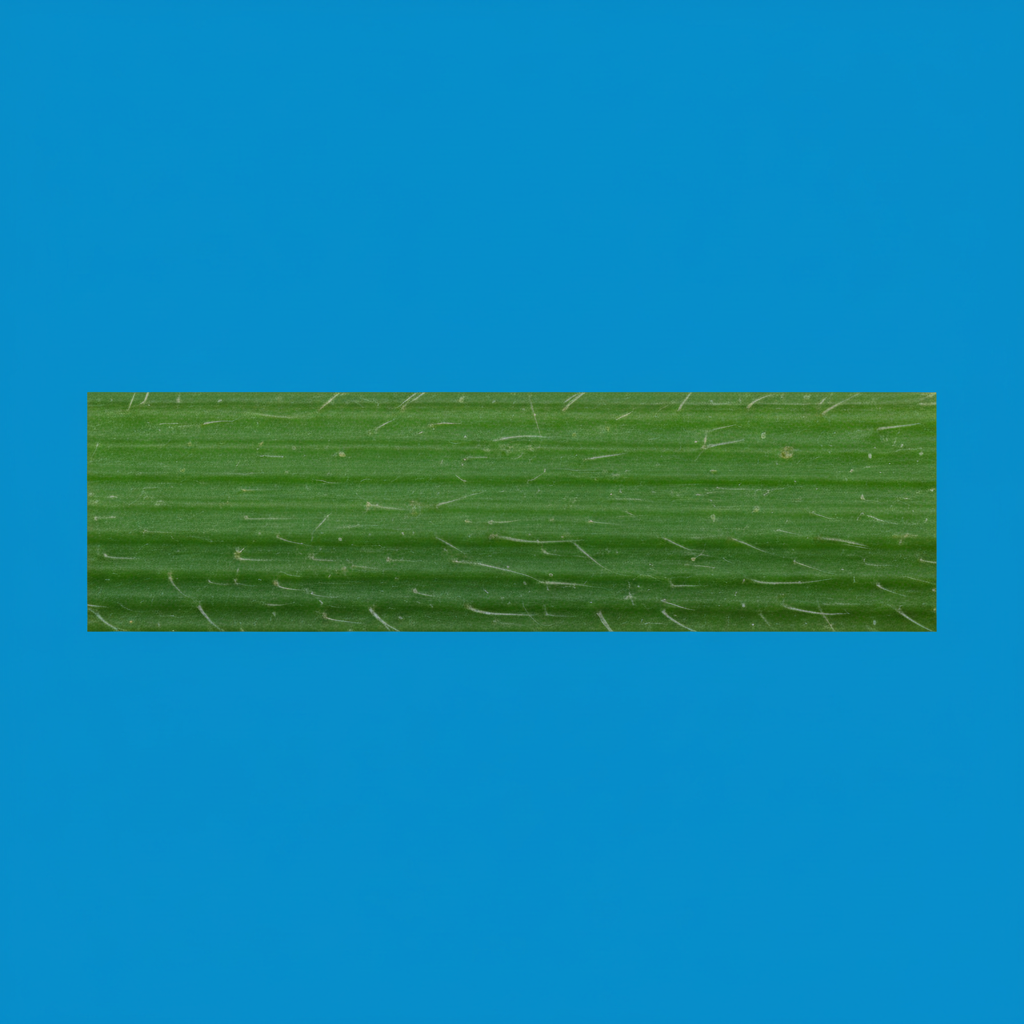

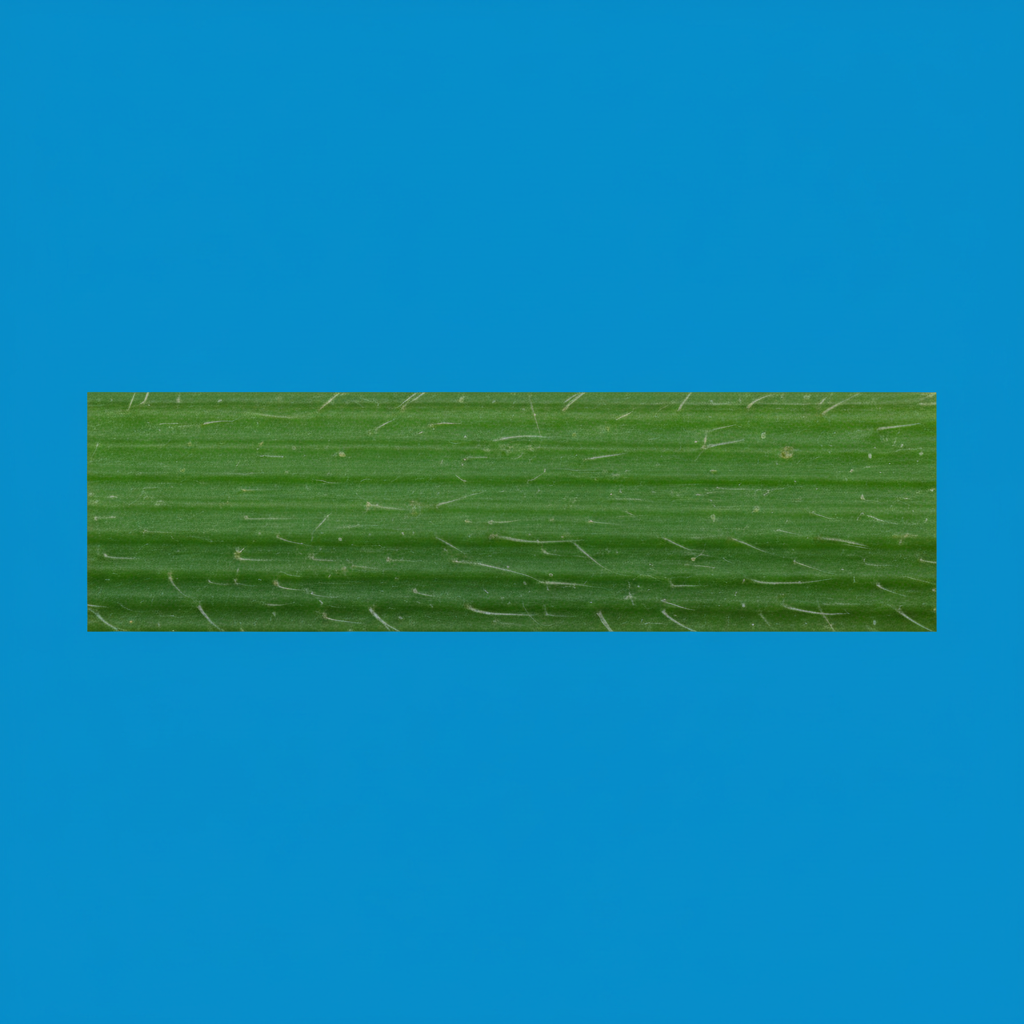

In [7]:
    prompt = "\n".join([
        "Create a detailed photorealistic strawberry stem texture that we can apply in a cylindrical mesh",
        "No branches and the background should be blue (far from any color in the leaf) for easy removal.",
        "It should be flattened out, no curvature. The image will be wrapped around a cylinder. ",
        "It should have minimal shadows.(Like a color map.)",
        "So the end result sould be a green rectangle (flat stem texture) with a blue background.",
        "Dont have highlights or shiny parts.",
    ])

    central_leaflet_color = query_image([prompt])
    display(central_leaflet_color)

Got multiple parts in response:
Here is the bump map for the strawberry stem texture: 
Got multiple parts in response:


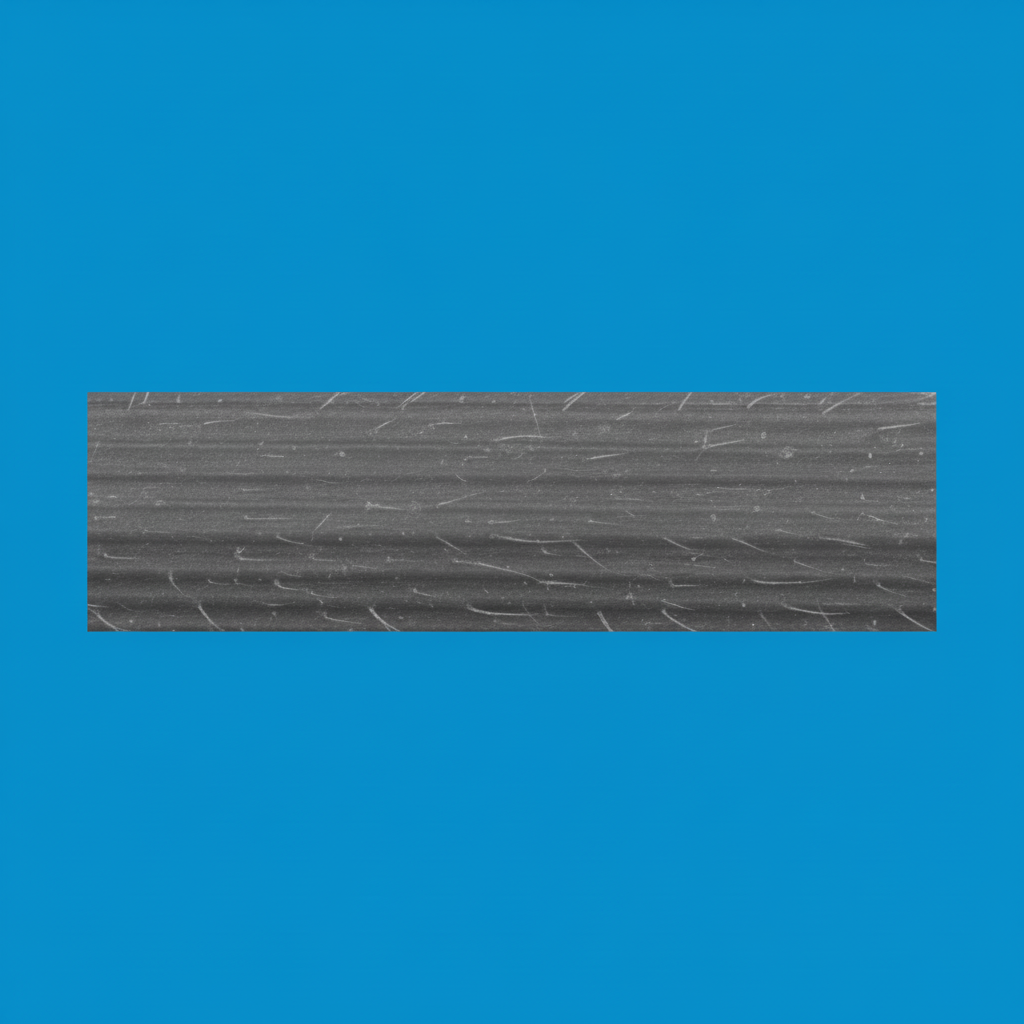

In [8]:
prompt = "\n".join([
    "This is the flattened color texture of a strawberry stem.",
    "Please create the bump map for this texture.",
    "A bump map is a grayscale image that represents surface height variations.",
])

central_leaflet_bump =  query_image([prompt, central_leaflet_color])


Background color: (7, 141, 203)


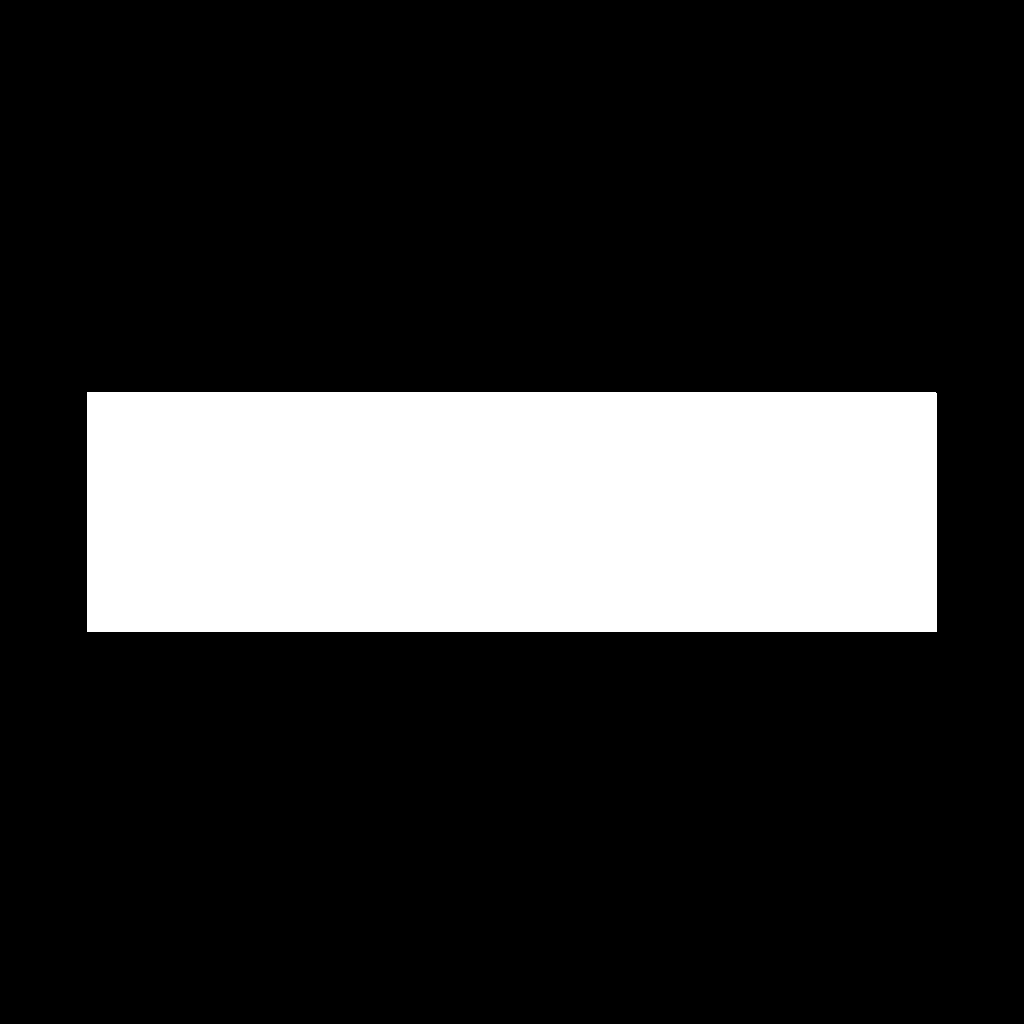

In [9]:
def create_alpha_mask(image, tolerance=50):
    """
    Create a black and white alpha mask using the top-left pixel color as the clip color.
    
    Args:
        image: PIL Image in RGB or RGBA mode
        tolerance: How close colors need to be to the clip color (0-255)
    
    Returns:
        PIL Image: Black and white mask where white=opaque, black=transparent
    """
    # Get the background color from top-left pixel
    clip_color = image.getpixel((0, 0))
    print("Background color:", clip_color)
    
    # Convert to RGB if needed for consistent processing
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    
    # Get image data as array
    data = image.getdata()
    mask_data = []
    
    for pixel in data:
        r, g, b = pixel[:3]  # Get RGB values
        cr, cg, cb = clip_color[:3]  # Handle both RGB and RGBA clip colors
        
        # Calculate color distance
        distance = ((r - cr) ** 2 + (g - cg) ** 2 + (b - cb) ** 2) ** 0.5
        
        if distance <= tolerance:
            # Background color = black (transparent)
            mask_data.append(0)
        else:
            # Foreground = white (opaque)
            mask_data.append(255)
    
    # Create new grayscale mask image
    mask = Image.new('L', image.size)
    mask.putdata(mask_data)
    return mask

# Create alpha mask using the new function
alpha_mask = create_alpha_mask(central_leaflet_color, tolerance=50)
display(alpha_mask)



Bounding box from mask: (87, 392, 937, 632)
Size: 850 x 240


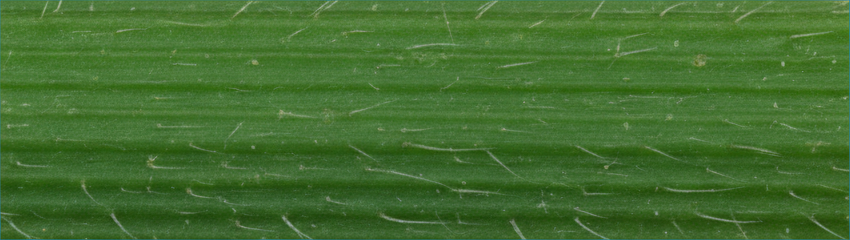

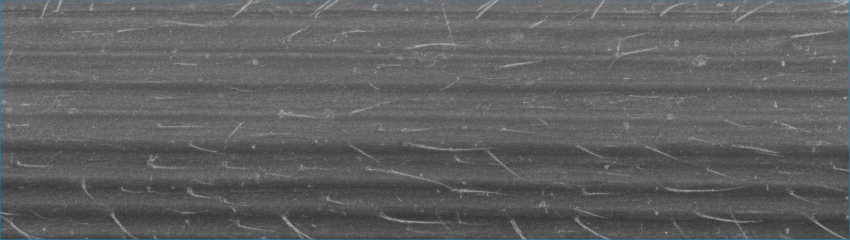

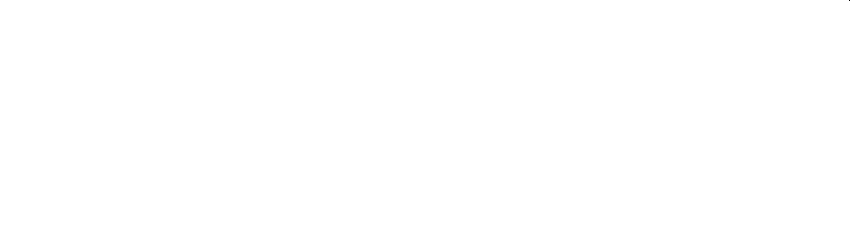

In [ ]:
from typing import Tuple


def get_bounding_box_from_mask(mask):
    """
    Get the bounding box of non-black pixels from an alpha mask.
    
    Args:
        mask: PIL Image in grayscale mode ('L') where white=content, black=background
    
    Returns:
        tuple: (left, top, right, bottom) bounding box or None if no content found
    """
    # For grayscale masks, getbbox() finds non-zero pixels
    bbox = mask.getbbox()
    if bbox:
        print(f"Bounding box from mask: {bbox}")
        print(f"Size: {bbox[2] - bbox[0]} x {bbox[3] - bbox[1]}")
    else:
        print("No content found in mask")
    return bbox

def crop_images_to_bbox(images, bbox: Tuple[int, int, int, int], padding=0):
    """
    Crop a list of images to the same bounding box.
    
    Args:
        images: List of PIL Images
        bbox: tuple (left, top, right, bottom) bounding box
        padding: number of pixels to expand the bounding box in all directions
    
    Returns:
        List of cropped PIL Images, all with the same size
    """
    if not images or not bbox:
        return images
    
    cropped_images = []
    for img in images:
        # Apply padding
        padded_bbox = (
            bbox[0] - padding,
            bbox[1] - padding,
            bbox[2] + padding,
            bbox[3] + padding
        )
        cropped = img.crop(padded_bbox)
        cropped_images.append(cropped)
    
    return cropped_images

# Get bounding box from the alpha mask
bbox = get_bounding_box_from_mask(alpha_mask)


# Now crop all images to the same bounding box
images_to_crop = [central_leaflet_color, central_leaflet_bump, alpha_mask]
cropped_images = crop_images_to_bbox(images_to_crop, bbox)

# Save and display the cropped images
central_leaflet_color_cropped = cropped_images[0]
central_leaflet_bump_cropped = cropped_images[1]
central_leaflet_mask_cropped = cropped_images[2]

display(central_leaflet_color_cropped)
display(central_leaflet_bump_cropped)
display(central_leaflet_mask_cropped)

/tmp/ipykernel_386311/1486251355.py:66: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  normal_map = Image.fromarray(normal_rgb, 'RGB')


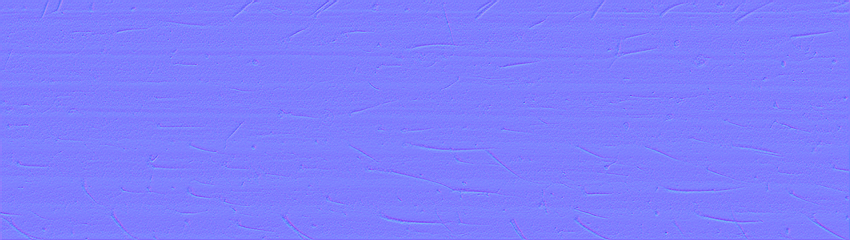

In [11]:
import numpy as np

def bump_to_normal(bump_image, strength=1.0):
    """
    Convert a grayscale bump map to a normal map.
    
    Args:
        bump_image: PIL Image in grayscale or RGB (will use luminance)
        strength: Multiplier for the normal strength (default 1.0)
    
    Returns:
        PIL Image: Normal map in RGB format
    """
    # Convert to grayscale array if needed
    if bump_image.mode == 'RGBA':
        # Use RGB channels, ignore alpha
        bump_array = np.array(bump_image.convert('RGB'))
        bump_gray = np.dot(bump_array[...,:3], [0.299, 0.587, 0.114])
    elif bump_image.mode == 'RGB':
        bump_array = np.array(bump_image)
        bump_gray = np.dot(bump_array, [0.299, 0.587, 0.114])
    else:
        bump_gray = np.array(bump_image.convert('L'))
    
    # Normalize to 0-1 range
    bump_gray = bump_gray.astype(np.float32) / 255.0
    
    # Calculate gradients (surface derivatives)
    grad_x = np.zeros_like(bump_gray)
    grad_y = np.zeros_like(bump_gray)
    
    # Calculate X gradient (horizontal)
    grad_x[:, 1:] = bump_gray[:, 1:] - bump_gray[:, :-1]
    grad_x[:, 0] = grad_x[:, 1]  # Duplicate edge
    
    # Calculate Y gradient (vertical) 
    grad_y[1:, :] = bump_gray[1:, :] - bump_gray[:-1, :]
    grad_y[0, :] = grad_y[1, :]  # Duplicate edge
    
    # Apply strength multiplier
    grad_x *= strength
    grad_y *= strength
    
    # Create normal vectors
    # Normal = (-dx, -dy, 1) normalized
    normal_x = -grad_x
    normal_y = -grad_y  
    normal_z = np.ones_like(grad_x)
    
    # Normalize the normal vectors
    length = np.sqrt(normal_x**2 + normal_y**2 + normal_z**2)
    normal_x /= length
    normal_y /= length  
    normal_z /= length
    
    # Convert from [-1,1] to [0,255] range
    # Normal map uses: R=X, G=Y, B=Z
    normal_r = ((normal_x + 1.0) * 0.5 * 255).astype(np.uint8)
    normal_g = ((normal_y + 1.0) * 0.5 * 255).astype(np.uint8)  
    normal_b = ((normal_z + 1.0) * 0.5 * 255).astype(np.uint8)
    
    # Stack into RGB image
    normal_rgb = np.stack([normal_r, normal_g, normal_b], axis=-1)
    
    # Convert back to PIL Image
    normal_map = Image.fromarray(normal_rgb, 'RGB')
    
    return normal_map

# Generate normal map from your bump map
central_leaflet_normal_cropped = bump_to_normal(central_leaflet_bump_cropped, strength=2.0)
display(central_leaflet_normal_cropped)

In [ ]:
central_leaflet_color_cropped.putalpha(central_leaflet_mask_cropped)

images = {
    "central_leaflet_color_cropped": central_leaflet_color_cropped,
    "central_leaflet_mask_cropped": central_leaflet_mask_cropped,
    "central_leaflet_bump_cropped": central_leaflet_bump_cropped,
    "central_leaflet_normal_cropped": central_leaflet_normal_cropped,
}

for name, img in images.items():
    img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
    # Resize to 1024x1024 for consistency
    img = img.resize((1024, 1024), resample=Image.LANCZOS)
    img.save(f"{name}.png")
    display(img)